In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [2]:
df = pd.read_csv('/Users/balmukundmishra/Desktop/2025-Learning/ML-Course/9_Problem_Statements/data/common.csv')

# Feature engineering
df['total_flow'] = df['flow_rate'] * (df['duration'] / 60.0)
df['flow_per_variability'] = df['total_flow'] / (df['variability'] + 1e-5)

# Convert time-related columns
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['minute'] = pd.to_datetime(df['time']).dt.minute
df['seconds'] = pd.to_datetime(df['time']).dt.second
df['day'] = df['day'].astype('category').cat.codes

# Drop unused
df = df.drop(columns=['time'])

# Target and features
X = df.drop(columns=['isleak']).values
y = df['isleak'].astype(int).values


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [4]:
class LeakDetectorNN(nn.Module):
    def __init__(self, input_dim):
        super(LeakDetectorNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

model = LeakDetectorNN(input_dim=X_train.shape[1])


In [5]:
# Class imbalance handling
pos_weight = torch.tensor([(len(y_train) - sum(y_train)) / sum(y_train)], dtype=torch.float32)

criterion = nn.BCELoss()  # You can also try nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
EPOCHS = 50
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")


Epoch 5/50 - Loss: 7.4231
Epoch 10/50 - Loss: 7.1248
Epoch 15/50 - Loss: 7.0467
Epoch 20/50 - Loss: 6.8746
Epoch 25/50 - Loss: 6.8365
Epoch 30/50 - Loss: 6.5921
Epoch 35/50 - Loss: 6.5634
Epoch 40/50 - Loss: 6.3672
Epoch 45/50 - Loss: 5.9701
Epoch 50/50 - Loss: 6.1451


In [7]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9885    1.0000    0.9942      1977
           1     0.0000    0.0000    0.0000        23

    accuracy                         0.9885      2000
   macro avg     0.4943    0.5000    0.4971      2000
weighted avg     0.9771    0.9885    0.9828      2000



/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

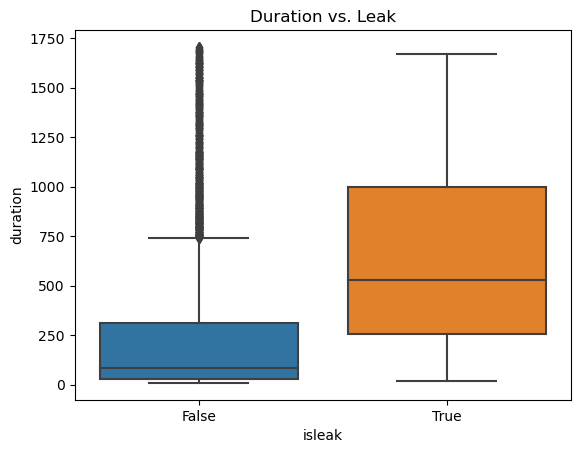

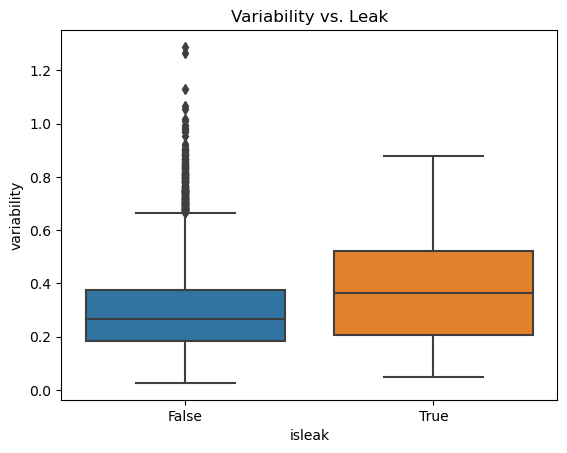

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare duration by leak status
sns.boxplot(data=df, x='isleak', y='duration')
plt.title('Duration vs. Leak')
plt.show()

# Compare variability
sns.boxplot(data=df, x='isleak', y='variability')
plt.title('Variability vs. Leak')
plt.show()


In [9]:
df['flow_var_ratio'] = df['flow_rate'] / (df['variability'] + 1e-5)
df['duration_var_ratio'] = df['duration'] / (df['variability'] + 1e-5)
df['is_night'] = df['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

<Axes: xlabel='isleak', ylabel='flow_var_ratio'>

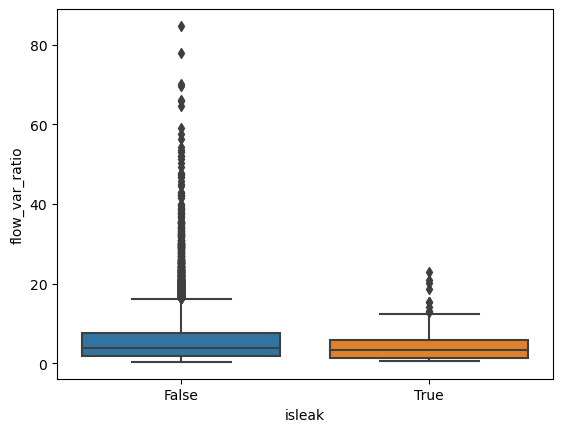

In [10]:
sns.boxplot(data=df, x='isleak', y='flow_var_ratio')

In [11]:
df['stable_high_flow'] = ((df['flow_rate'] > 1.5) & 
                          (df['variability'] < 0.2) & 
                          (df['duration'] > 60)).astype(int)

<Axes: xlabel='stable_high_flow', ylabel='count'>

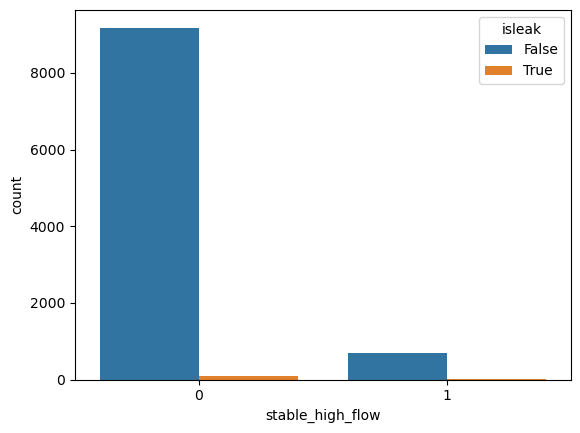

In [12]:
sns.countplot(x='stable_high_flow', hue='isleak', data=df)

In [13]:
from sklearn.ensemble import IsolationForest

X_features = df.drop(columns=['isleak'])  # Include engineered features
iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = iso.fit_predict(X_features)

# Convert to 1 = anomaly (leak), 0 = normal
df['predicted_isleak'] = (df['anomaly_score'] == -1).astype(int)

from sklearn.metrics import classification_report
print(classification_report(df['isleak'], df['predicted_isleak']))

/Users/balmukundmishra/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

       False       0.99      0.99      0.99      9886
        True       0.02      0.02      0.02       114

    accuracy                           0.98     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.98      0.98      0.98     10000



In [15]:
df['leak_rule'] = ((df['duration'] > 120) & 
                   (df['variability'] < 0.2) & 
                   (df['hour'] < 5)).astype(int)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(df['isleak'], df['leak_rule']))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98      9886
        True       0.02      0.06      0.03       114

    accuracy                           0.96     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.98      0.96      0.97     10000



In [14]:
df['suspicious_rule'] = ((df['hour'] < 5) & (df['flow_rate'] > 2) & 
                         (df['variability'] < 0.2)).astype(int)